1. Import all the necessary libraries.
2. Load the dataset.
3. Preprocess the data.
4. Determine the number of Gaussian mixtures(n_components) to use by computing the BIC score.
5. Fit the model
6. Detect the anomaly by using some anomaly metric.
    For example: If the non-anomalous data is Gaussian with some mean and variance, the points that receive low probability assignments under the chosen prior may be flagged as anomalous. 

** STEP 1 **

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [2]:
import itertools
from scipy import linalg
import matplotlib as mpl

**STEP 2**

In [3]:
df = pd.read_csv('Torschlag_Trafo_07122015_to_11122015.csv', sep=',')

In [4]:
df_filt = df[["V1","V2","V3","I1","I2","I3","Pges","Sges","CosPhi"]]

In [5]:
df_filt.shape

(380648, 9)

**STEP 3**

In [6]:
Std_data = StandardScaler().fit_transform(df_filt)

In [7]:
Std_data

array([[-0.48778673, -0.69823107, -0.71288956, ...,  2.93609279,
         2.96073279,  0.73869058],
       [-0.57887644, -0.76036342, -0.77897396, ...,  2.97444359,
         2.98222249,  1.01825551],
       [-0.57887644, -0.76036342, -0.77897396, ...,  2.97444359,
         2.98222249,  1.01825551],
       ..., 
       [ 2.4270839 ,  2.29541834,  2.4591617 , ..., -0.81344742,
        -0.8242239 , -1.49782884],
       [ 2.4270839 ,  2.29541834,  2.4591617 , ..., -0.81344742,
        -0.8242239 , -1.49782884],
       [ 2.4270839 ,  2.29541834,  2.4591617 , ..., -0.81344742,
        -0.8242239 , -1.49782884]])

**STEP 4**

A GaussianMixture.fit method is provided that learns a Gaussian Mixture Model from train data. Given test data, it can assign to each sample the Gaussian it mostly probably belong to using the GaussianMixture.predict method.

In [8]:
def compute_bic(X):
    cv_types = ['spherical', 'tied', 'diag', 'full']
    lowest_bic = np.infty
    bic = []
    n_components_range = range(1,10)
    for cv_type in cv_types:
        for n in n_components_range:
            gmm = GaussianMixture(n_components = n, covariance_type='full')
            gmm.fit(X)
            bic.append(gmm.bic(X))
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm
    bic = np.array(bic)
    return best_gmm, bic

In [9]:
def plot_bic(best_gmm, bic, X):
    cv_types = ['spherical', 'tied', 'diag', 'full']
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                              'darkorange'])
    clf = best_gmm
    bars = []
    n_components_range = range(1,10)
    
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title('BIC score per model')
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +.2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)
    
    # Plot the winner
    splot = plt.subplot(2, 1, 2)
    Y_ = clf.predict(X)
    for i, (mean, cov, color) in enumerate(zip(clf.means_, clf.covariances_,color_iter)):
        v, w = linalg.eigh(cov)
        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)
        
        # Plot an ellipse to show the Gaussian component
        angle = np.arctan2(w[0][1], w[0][0])
        angle = 180. * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(mean, v[0], v[1], 180. + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(.5)
        splot.add_artist(ell)
    
    plt.xticks(())
    plt.yticks(())
    plt.title('Selected GMM: full model, 2 components')
    plt.subplots_adjust(hspace=.35, bottom=.02)
    plt.show()
    

In [10]:
best_gmm, bic = compute_bic(Std_data)


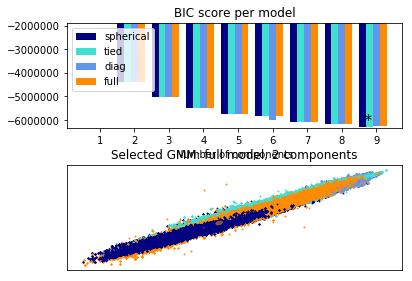

In [11]:
plot_bic(best_gmm, bic, Std_data)

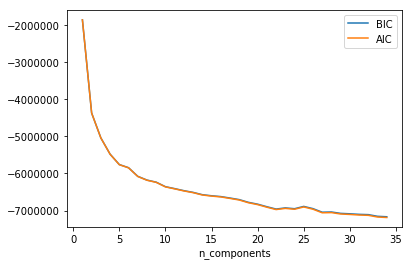

In [12]:
n_components = np.arange(1, 35)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(Std_data)
          for n in n_components]

plt.plot(n_components, [m.bic(Std_data) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Std_data) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');



In [13]:
best_gmm.predict(Std_data)

array([1, 1, 1, ..., 2, 2, 2])

**STEP 5**

In [14]:
def fit_data(data):
    gmix = mixture.GMM(n_components=2, covariance_type='full')
    gmix.fit(data)
    print gmix.means_
    colors = ['r' if i==0 else 'g' for i in gmix.predict(data)]
    ax = plt.gca()
    ax.scatter(data[:,0], data[:,1], c=colors, alpha=0.8)
    plt.show()

**STEP 6**